## Imports

In [ ]:
!pip install eli5
!pip install shap

In [1]:
import pandas as pd 
import numpy as np
import sklearn
import pickle
import matplotlib.pyplot as plt
import lazypredict
import xgboost as xgb
import eli5

from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score

from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import shap

## Load data using maximum number of feature (75)

In [2]:
# Load X_train
with open('X_train_75.npy', 'rb') as f:
    X_train = np.load(f)
print(X_train.shape)
X_train

(9000, 75)


array([[-8.81665000e-01,  1.04447100e+00,  1.59010940e-01, ...,
         7.64136797e-02,  2.23461397e-02,  1.29471645e+01],
       [-1.10552300e+00,  1.12647200e+00,  1.74547752e-01, ...,
         1.13979068e-01,  2.85805084e-02,  1.38184886e+01],
       [-2.64679000e+00,  3.47160000e-02, -1.61696002e+00, ...,
         7.77954261e-02,  3.10021816e-02,  1.33114980e+01],
       ...,
       [-1.56939900e+00,  8.21211000e-01, -4.06112460e-01, ...,
         1.29546035e-01,  3.10393141e-02,  1.38336216e+01],
       [-1.09474900e+00,  1.15340700e+00,  8.15228667e-03, ...,
         1.52495097e-01,  4.72684630e-02,  1.39800549e+01],
       [-1.13664700e+00,  8.64905000e-01, -5.17633651e-01, ...,
         5.24448737e-02,  3.02990790e-02,  1.37358806e+01]])

In [3]:
# Load y_train
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
print(y_train.shape)
y_train

(9000,)


array([ 7, 13,  6, ...,  3,  3, 18], dtype=int64)

In [4]:
# Load X_test
with open('X_test_75.npy', 'rb') as f:
    X_test = np.load(f)
print(X_test.shape)
X_test

(5000, 75)


array([[-1.83755000e+00,  1.38265100e+00, -3.05412347e-01, ...,
         1.69465441e-01,  4.55106589e-02,  1.37640621e+01],
       [-1.74357700e+00,  1.61488900e+00, -3.54157081e-01, ...,
         9.01118934e-02,  3.03245873e-02,  1.29569175e+01],
       [-1.87047000e+00, -2.16077000e-01, -8.47212227e-01, ...,
         1.27677673e-01,  2.67303936e-02,  1.39464683e+01],
       ...,
       [-6.30872000e-01,  6.78756000e-01,  4.29758667e-03, ...,
         5.26696304e-02,  2.91492287e-02,  1.29786762e+01],
       [-2.13143800e+00,  4.72850000e-02, -1.05151830e+00, ...,
         7.00060125e-02,  2.16020454e-02,  1.42111488e+01],
       [-1.54605600e+00,  2.98677000e-01, -5.40031205e-01, ...,
         1.12113293e-01,  2.19392284e-02,  1.25388069e+01]])

In [5]:
# Create validation data
# Train/test sets
X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42
)

### Features

In [6]:
features = ["min_x", "max_x", "mean_x", "std_x", "skew_x", "kurt_x", "med_x", "max_min_x", "neg_x", "poz_x", "above_mean_x", "energy_x", "mad_x", "iqr_x", "ent_x", "peaks_x", \
       "min_y", "max_y", "mean_y", "std_y", "skew_y", "kurt_y", "med_y", "max_min_y", "neg_y", "poz_y", "above_mean_y", "energy_y", "mad_y", "iqr_y", "ent_y", "peaks_y", \
       "min_z", "max_z", "mean_z", "std_z", "skew_z", "kurt_z", "med_z", "max_min_z", "neg_z", "poz_z", "above_mean_z", "energy_z", "mad_z", "iqr_z", "ent_z", "peaks_z", \
       "min_a", "max_a", "mean_a", "std_a", "skew_a", "kurt_a", "med_a", "max_min_a", "above_mean_a", "energy_a", "mad_a", "iqr_a", "ent_a", "peaks_a", \
       "corr_xy", "corr_xz", "corr_yz", "corr_ax", "corr_ay", "corr_az", "ang_xy", "ang_xz", "ang_yz", "ang_ax", "ang_ay", "ang_az", "sma"]

## First train an ExtraTreesClassifier and try to explain features

In [7]:
etc_clf = ExtraTreesClassifier(random_state=42, n_jobs=-1, warm_start=True, max_depth=30, min_samples_split=2, \
                               min_samples_leaf=1, n_estimators=2000)

In [8]:
etc_clf.fit(X_train_from_train, y_train_from_train)

ExtraTreesClassifier(max_depth=30, n_estimators=2000, n_jobs=-1,
                     random_state=42, warm_start=True)

In [9]:
perm_imp = eli5.sklearn.PermutationImportance(etc_clf, random_state=69).fit(X_val_from_train, y_val_from_train)
eli5.show_weights(perm_imp, feature_names = features, top=75)

Weight,Feature
0.0036 ± 0.0043,corr_yz
0.0033 ± 0.0024,energy_a
0.0024 ± 0.0036,corr_ay
0.0020 ± 0.0036,corr_ax
0.0020 ± 0.0009,corr_xz
0.0016 ± 0.0023,max_z
0.0013 ± 0.0022,min_y
0.0013 ± 0.0017,kurt_z
0.0007 ± 0.0011,above_mean_z
0.0007 ± 0.0011,mad_x


## Let's train Catboost and see if we get a similar feature importance

In [ ]:
cbc = CatBoostClassifier(loss_function='MultiClass', task_type="GPU")

In [ ]:
cbc.fit(X_train_from_train, y_train_from_train)

In [ ]:
eli5.explain_weights(cbc, top=75, importance_type='PredictionValuesChange', feature_names=features)

In [ ]:
perm_imp = eli5.sklearn.PermutationImportance(cbc, random_state=69).fit(X_val_from_train, y_val_from_train)
eli5.show_weights(perm_imp, feature_names = features, top=75)

## SHAP Values

In [9]:
etc_clf = ExtraTreesClassifier()
etc_clf.fit(X_train_from_train, y_train_from_train)

ExtraTreesClassifier()

In [10]:
shap_explainer = shap.TreeExplainer(etc_clf)
shap_values = shap_explainer.shap_values(X_val_from_train, approximate=True)

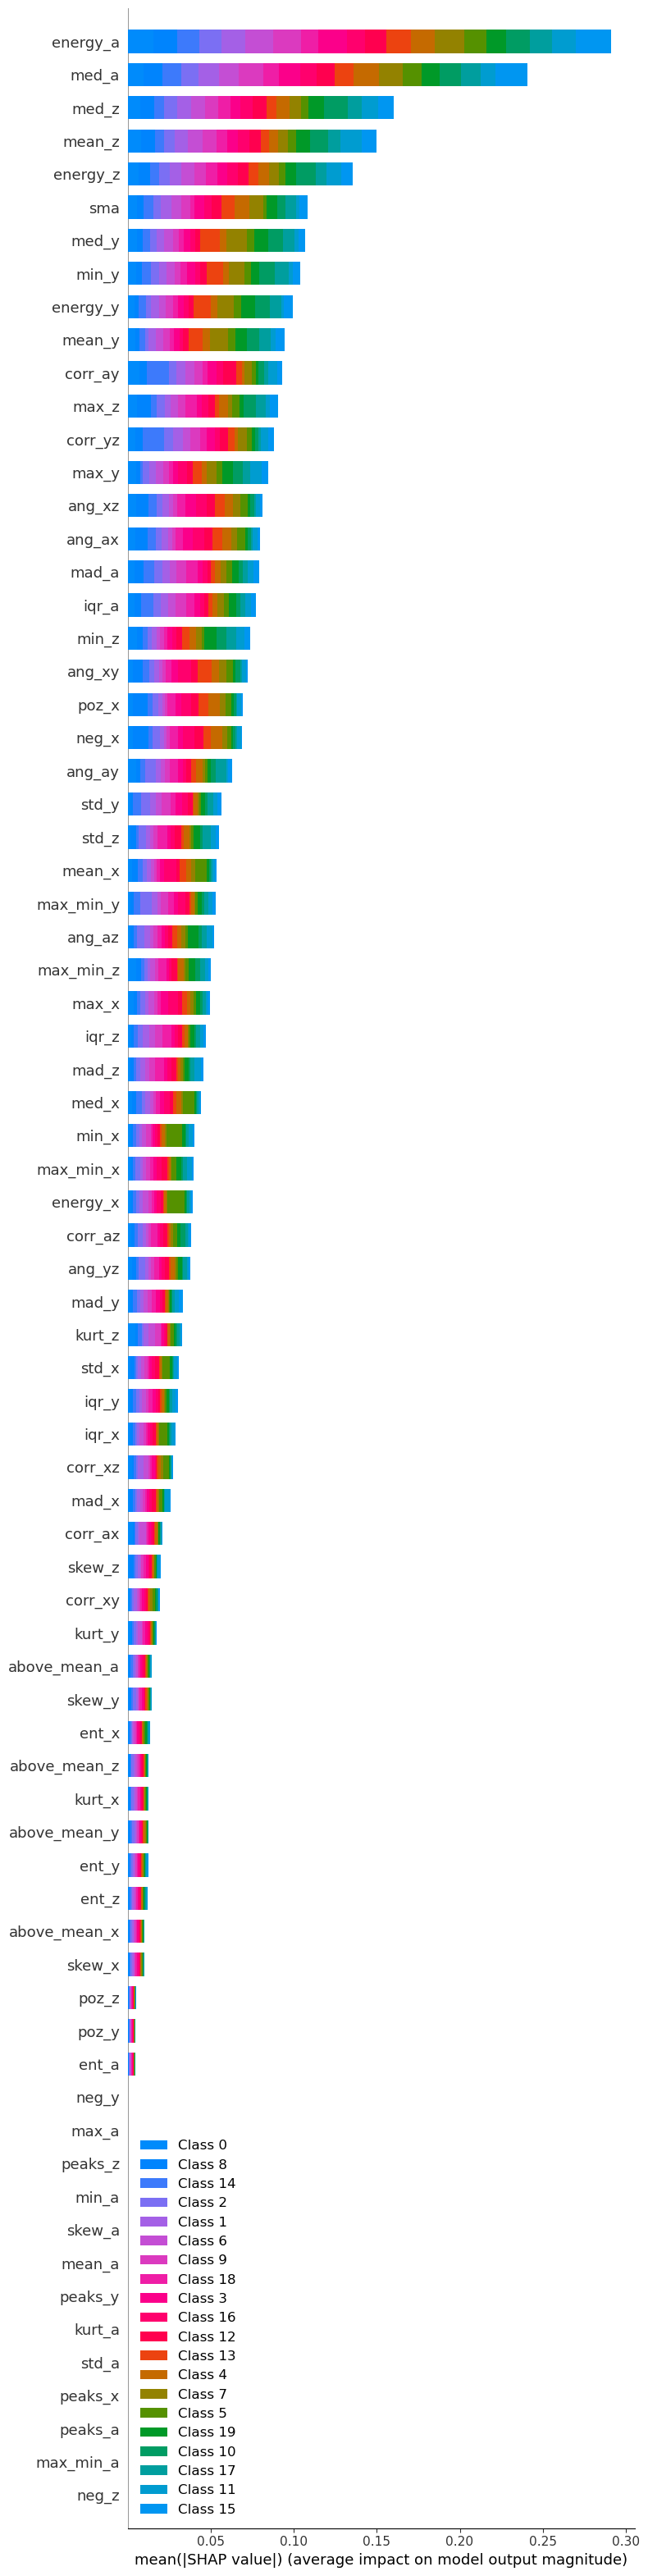

In [12]:
shap.summary_plot(shap_values, X_val_from_train, max_display=X_val_from_train.shape[1], show=False, feature_names=features)